# Rhetorical and sentiment analysis

# Imports 

In [1]:
import simplejson
import numpy as np
from glob import glob
from bs4 import BeautifulSoup
from datetime import datetime
from os.path import basename, join
from pprint import pprint
import re
import pickle 
import cPickle
import pandas as pd

from pprint import pprint
from datetime import datetime
from tqdm import tqdm
from tqdm import tnrange, tqdm_notebook
from time import sleep

from joblib import Parallel, delayed

import networkx as nx
from operator import itemgetter
import matplotlib.pyplot as plt

import sys
sys.path.append("/root/sa/edu_dependency_parser/src")
from trees.parse_tree import ParseTree

import requests
import simplejson
import operator

from wordcloud import WordCloud

%matplotlib inline

In [2]:
import spacy
nlp = spacy.load('en')

# Aspect-based sentiment analysis flow - texual data summarization 

<img src="Rhetorical analysis - Flow croped.png">

# Exemplary Discourse Tree

<img src="Rhetorical Analysis example.png">

# Load parsed data 

In [4]:
data_path = '/datasets/sentiment/aspects/results/brexit-preprocessed-news-all/'
# data_path = '/datasets/sentiment/aspects/results/2015-2016_CRUISE-SERVICE/'
data_path = '/datasets/sentiment/aspects/results/brexit-event-eng-body-no-lemma/'

In [5]:
def load_serialized(f_path, f_name):
    with open(join(f_path, f_name)) as f:
        obj = cPickle.load(f)
    return obj

In [6]:
aspect_graph = load_serialized(data_path, 'aspects_graph') 

IOError: [Errno 2] No such file or directory: '/datasets/sentiment/aspects/results/brexit-event-eng-body-no-lemma/aspects_graph'

## Sentiment EDUs load

In [6]:
sent_edu = load_serialized(data_path, 'sentiment_filtered_edus')

In [7]:
len(sent_edu)

88799

In [8]:
sent_edu.items()[:3]

[(0,
  {'entities': [u'the european union', u'uk'],
   'raw_text': u'X Students from the European Union starting university courses in the UK this autumn will have their student loans funding honoured ,',
   'sentiment': array([1]),
   'source_document_id': 0,
   'tokens': [{'is_stop': False, 'lemma': u'x', 'pos': u'NOUN', 'text': u'X'},
    {'is_stop': False,
     'lemma': u'student',
     'pos': u'NOUN',
     'text': u'Students'},
    {'is_stop': True, 'lemma': u'from', 'pos': u'ADP', 'text': u'from'},
    {'is_stop': True, 'lemma': u'the', 'pos': u'DET', 'text': u'the'},
    {'is_stop': False,
     'lemma': u'european',
     'pos': u'PROPN',
     'text': u'European'},
    {'is_stop': False, 'lemma': u'union', 'pos': u'PROPN', 'text': u'Union'},
    {'is_stop': False, 'lemma': u'start', 'pos': u'VERB', 'text': u'starting'},
    {'is_stop': False,
     'lemma': u'university',
     'pos': u'NOUN',
     'text': u'university'},
    {'is_stop': False, 'lemma': u'course', 'pos': u'NOUN', '

## Aspects load 

In [9]:
aspect_edu = load_serialized(data_path, 'aspects_per_edu')

### Summarize sentiment per aspect

In [10]:
def graph_stats(graph):
    n_n = len(graph.nodes())
    n_e = len(graph.edges())
    print '#Nodes: {}'.format(n_n)
    print '#Edges: {}'.format(n_e)
    print 'Connections coverage: {}%'.format(( float(n_e) / (n_n * n_n ) * 100))

    degree_sequence=sorted(nx.degree(graph).values(),reverse=True) # degree sequence
    dmax=max(degree_sequence)

    print '-'*30
    print 'Highest degree of nodes'
    nd=sorted(aspect_graph.degree_iter(), key=itemgetter(1), reverse=True)
    df_nd = pd.DataFrame(nd, columns=['aspect', 'degree'])
    #     pprint([x for x in nd if len(x[0]) > 1]) # filter out aspect consists of one letter

    print '-'*30
    print 'Page Rank'
    pg = nx.pagerank(aspect_graph)
    df_pg = pd.DataFrame(pg.items(), columns=['aspect', 'pagerank'])
    # pgs = [(node, pagerank) for node, pagerank in pg.items()]
    #     pprint(pgs[:top_n])
    print '-'*30
    pprint('Unique Values of Page Rank: {}, unique nodes: {}'.format(len(set([pagerank for node, pagerank in pg.items()])), n_n))
    doc_asp_sent = []
    for doc_id, aspects in aspect_edu.iteritems():
        for aspect in aspects:
            doc_asp_sent.append((aspect, sent_edu[doc_id]['sentiment'][0]))

    df = pd.DataFrame()
    df['aspect'] = [x[0] for x in doc_asp_sent]
    df['sentiment'] = [x[1] for x in doc_asp_sent]

    df_mean = df.groupby('aspect').mean().reset_index().sort_values('sentiment', ascending=False)
    df_mean.columns = ['aspect', 'mean_sent']
    df_sum = df.groupby('aspect').sum().reset_index().sort_values('sentiment', ascending=False)
    df_sum.columns = ['aspect', 'sum_sent']

    df = pd.merge(df_mean, df_sum, on='aspect')
    df = pd.merge(df, df_pg, on='aspect')
    df = pd.merge(df, df_nd, on='aspect')

    df = df[[u'aspect', u'mean_sent', u'sum_sent', 'pagerank', 'degree']]

    return doc_asp_sent, df

In [11]:
doc_asp_sent, df = graph_stats(aspect_graph)

#Nodes: 53358
#Edges: 869860
Connections coverage: 0.0305527477979%
------------------------------
Highest degree of nodes
------------------------------
Page Rank
------------------------------
'Unique Values of Page Rank: 37437, unique nodes: 53358'


In [12]:
# doc_asp_sent, df = graph_stats(aspect_graph)

In [13]:
# df.sort_values(by='pagerank', ascending=False)

In [20]:
aspects_to_remove = [u'day', u'days', u'week', u'weeks', u'month', u'months', u'year', u'years', 
                     u'time', u'today', u'data', u'date',
                     u'monday', u'tuesday', u'wednesday', u'thursday', u'friday', u'saturday', u'sunday', 
                     u'january', u'february', u'march', u'april', u'may', u'june', u'july',
                     u'august', u'september', u'october', u'november', u'december',
                     u'end']

In [21]:
df_filtered = df[ ( df.aspect.str.len() > 1 ) & ( ~df.aspect.isin( aspects_to_remove )) ]

In [17]:
# df_filtered.sort_values(by='degree', ascending=False).to_excel('/datasets/sentiment/aspects/results/brexit-preprocessed-news-all.aspects.xls',
#                                                             encoding='utf8')

In [22]:
df_filtered.sort_values(by='degree', ascending=False).head(150)

,aspect,mean_sent,sum_sent,pagerank,degree
27069,britain,0.703093,2046,0.009777,13147
29188,eu,0.263242,656,0.009065,11493
27973,uk,0.445876,692,0.006096,8574
27237,the european union,0.608487,889,0.003764,8317
29831,vote,0.081481,99,0.004455,7123
29612,country,0.157205,144,0.003832,6297
29727,brexit,0.122353,104,0.003004,5510
28201,europe,0.335188,241,0.002827,4854
29062,referendum,0.322078,248,0.002583,4748
29936,people,0.004992,3,0.003069,4618


### UK related aspect and different sentiment orientation 

In [23]:
df_filtered[df_filtered.aspect.isin(['great britain', 'united kingdom', 'uk', 'u.k'])].sort_values('pagerank', ascending=False)

,aspect,mean_sent,sum_sent,pagerank,degree
27973,uk,0.445876,692,0.006096,8574
26850,great britain,0.941176,32,0.000153,391
28356,united kingdom,0.333333,7,0.000058,224
28270,u.k,0.333333,1,0.000012,26


## Page Rank based aspect  

In [24]:
def draw_wordcloud(counts):
    wordcloud = WordCloud(background_color="white").generate_from_frequencies(counts)
    plt.figure(figsize=(9, 12))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

In [25]:
df_filtered.sort_values('pagerank', ascending=False).head(50)

,aspect,mean_sent,sum_sent,pagerank,degree
27069,britain,0.703093,2046,0.009777,13147
29188,eu,0.263242,656,0.009065,11493
27973,uk,0.445876,692,0.006096,8574
29831,vote,0.081481,99,0.004455,7123
29612,country,0.157205,144,0.003832,6297
27237,the european union,0.608487,889,0.003764,8317
29936,people,0.004992,3,0.003069,4618
29727,brexit,0.122353,104,0.003004,5510
28201,europe,0.335188,241,0.002827,4854
33638,company,-0.334711,-162,0.002797,3927


In [26]:
print 'Page Rank stats:'
print 'Mean:', df_filtered.pagerank.mean()
print 'Min: ', df_filtered.pagerank.min()
print 'Max: ', df_filtered.pagerank.max()

Page Rank stats:
Mean: 1.83517764317e-05
Min:  4.9403864485e-06
Max:  0.00977660192245


In [27]:
def draw_top_aspects_by_col(df=df_filtered, col='pagerank', top_n=100, ascending=False, pagerank_min=0.00005, min_degree=None):
    counts = []
    if min_degree is not None:
        df = df[df.degree > min_degree]
    for _, row in df[df.pagerank > pagerank_min].sort_values(col, ascending=ascending).head(top_n)[['aspect', col]].iterrows():
        counts.append((row['aspect'], row[col]))
    draw_wordcloud(counts)
    print counts

### TOP100 aspects based on pagerank

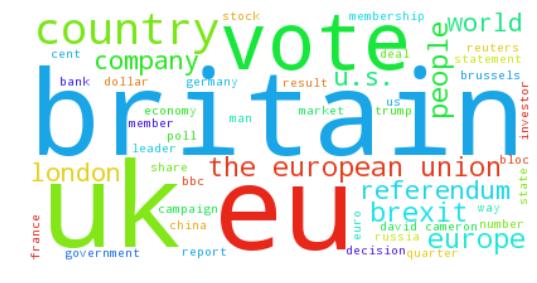

[(u'britain', 0.00977660192245076), (u'eu', 0.009064533822744865), (u'uk', 0.006095853469459083), (u'vote', 0.004454996156548538), (u'country', 0.0038322442862851087), (u'the european union', 0.003763614944529998), (u'people', 0.003069351461464315), (u'brexit', 0.003004476173351011), (u'europe', 0.00282693176155005), (u'company', 0.002797104292787691), (u'referendum', 0.002582818827111774), (u'london', 0.0020239583824278114), (u'world', 0.0019278766386118778), (u'u.s.', 0.0018442349940506197), (u'government', 0.0017560483207826488), (u'us', 0.0016830025720708656), (u'report', 0.001653835239537992), (u'leader', 0.001590050445345773), (u'share', 0.0015274438194282627), (u'dollar', 0.0015082998925860262), (u'investor', 0.0014570616645649414), (u'statement', 0.0014230609705945712), (u'economy', 0.0014112994560038406), (u'campaign', 0.0013760500104383502), (u'decision', 0.0013599292462020199), (u'market', 0.0013591782951715228), (u'david cameron', 0.0013536221101656803), (u'germany', 0.0013

In [28]:
draw_top_aspects_by_col(col='pagerank', top_n=50)

## Sentiment of the aspects 

In [29]:
def draw_top_aspects_by_sent(df=df_filtered, col='mean_sent', top_n=100, pagerank_min=0.00005, 
                             min_degree=None, sentiment='positive'):
    counts = []
    
    # only positive of negative sentiment
    if sentiment in ['positive']:
        df = df[df.mean_sent > 0]
    elif sentiment in ['negative']:
        df = df[df.mean_sent < 0]
        # the higher sentiemtn the bigger word, reverse sign 
        df.mean_sent = df.mean_sent.apply(lambda x: x * (-1))
    else:
        raise 'Wrong sentiment variable, should be positive or negative only'
    
#     df = df[df.degree > min_degree]
#     print df
    
    if min_degree is not None:
        df = df[df.degree > min_degree]
    
    for _, row in df[df.pagerank > pagerank_min].sort_values(['degree', col], ascending=False).head(top_n)[['aspect', col]].iterrows():
        counts.append((row['aspect'], row[col]))
    
    print counts
    draw_wordcloud(counts)

### Positive

[(u'britain', 0.7030927835051546), (u'eu', 0.26324237560192615), (u'uk', 0.44587628865979384), (u'the european union', 0.6084873374401095), (u'vote', 0.08148148148148149), (u'country', 0.1572052401746725), (u'brexit', 0.1223529411764706), (u'europe', 0.33518776077885953), (u'referendum', 0.3220779220779221), (u'people', 0.004991680532445923), (u'reuters', 0.5726495726495726), (u'world', 0.32210526315789473), (u'us', 0.1487603305785124), (u'leader', 0.1006423982869379), (u'david cameron', 0.10441767068273092), (u'government', 0.39378238341968913), (u'investor', 0.16981132075471697), (u'decision', 0.68), (u'economy', 0.3854166666666667), (u'campaign', 0.3850415512465374), (u'market', 0.08868501529051988), (u'share', 0.4836795252225519), (u'brussels', 0.22255192878338279), (u'germany', 0.3968253968253968), (u'stock', 0.32894736842105265), (u'way', 0.26141078838174275), (u'statement', 0.1504424778761062), (u'france', 0.4883720930232558), (u'number', 0.12757201646090535), (u'member', 0.4017

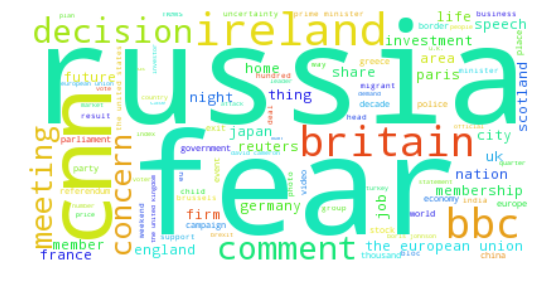

In [30]:
draw_top_aspects_by_sent(min_degree=100)

### Negative

[(u'london', 0.21951219512195122), (u'company', 0.3347107438016529), (u'u.s.', 0.011363636363636364), (u'report', 0.3903133903133903), (u'dollar', 0.665943600867679), (u'morning', 0.02564102564102564), (u'poll', 0.12538226299694188), (u'state', 0.23529411764705882), (u'risk', 0.4218009478672986), (u'bank', 0.2017167381974249), (u'donald trump', 0.6510638297872341), (u'euro', 0.2066115702479339), (u'cent', 0.7703349282296651), (u'datum', 0.2727272727272727), (u'money', 0.6206896551724138), (u'source', 0.525), (u'pound', 0.291866028708134), (u'woman', 0.09933774834437085), (u'president', 0.30538922155688625), (u'trump', 0.01675977653631285), (u'sale', 0.0547945205479452), (u'yesterday', 0.3383458646616541), (u'loss', 0.5037593984962406), (u'sterling', 0.7225433526011561), (u'labour', 0.02040816326530612), (u'region', 0.1774193548387097), (u'survey', 0.17142857142857143), (u'obama', 0.6923076923076923), (u'talk', 0.44642857142857145), (u'value', 0.14814814814814814), (u'barack obama', 0.7

/usr/local/lib/python2.7/dist-packages/pandas/core/generic.py:2701: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


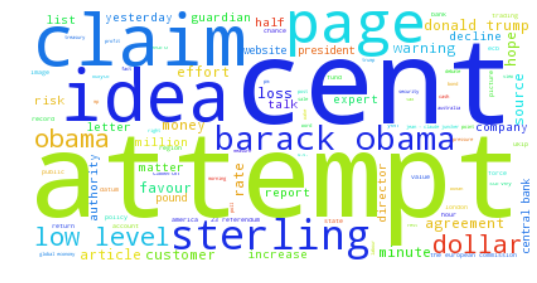

In [31]:
draw_top_aspects_by_sent(sentiment='negative')